In [9]:
from openpiv import windef
# from openpiv.piv import simple_piv
    
from openpiv import tools, scaling, validation, filters, preprocess
import openpiv.pyprocess as process
from openpiv import pyprocess
import numpy as np
import pathlib
import warnings


import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 8.0)

In [10]:
settings = windef.PIVSettings()
settings.filepath_images = pathlib.Path("C:/Users/estal/OneDrive - ROCKWOOL Group/Documents/GD/Thesis/04_Code/src/data/external/23-10/HighSpeedCamera/15.23/frames-postprocess-1/")

In [44]:
def simple_piv(im1, im2, plot=True):
    """
    Simplest PIV run on the pair of images using default settings

    piv(im1,im2) will create a tmp.vec file with the vector filed in pix/dt
    (dt=1) from two images, im1, im2 provided as full path filenames
    (TIF is preferable, whatever imageio can read)

    """
    if isinstance(im1, str):
        im1 = tools.imread(im1)
        im2 = tools.imread(im2)

    u, v, s2n = pyprocess.extended_search_area_piv(
        im1.astype(np.int32), im2.astype(np.int32), window_size=16,
        overlap=8, search_area_size=16
    )
    x, y = pyprocess.get_coordinates(image_size=im1.shape,
                                     search_area_size=16, overlap=8)

    valid = s2n > np.percentile(s2n, 50)

    if plot:
        _, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(im1, cmap=plt.get_cmap("gray"), alpha=0.5, origin="upper")
        ax.quiver(x[valid], y[valid], u[valid], -v[valid], scale=70,
                  color='r', width=.005)
        plt.show()
        
    # conform with the windef and tools.display_vector_field
    x,y,u,v = tools.transform_coordinates(x,y,u,v)

    return x, y, u, v, s2n


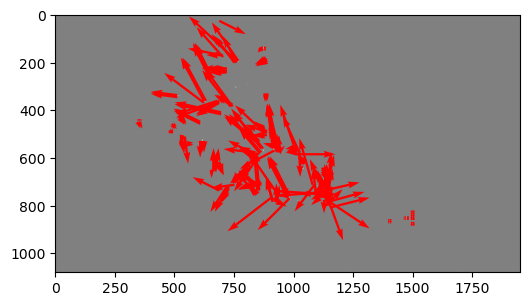

In [45]:
files = sorted(settings.filepath_images.glob('*.tif'))
from openpiv.tools import imread
simple_piv(imread(files[263]), imread(files[264]));

pca to the images to reduce the image resolution


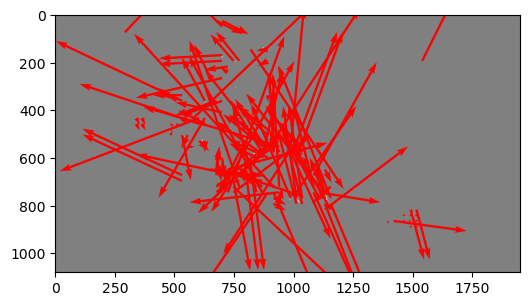

In [ ]:
def extended_search_area_piv(
    frame_a: np.ndarray,
    frame_b: np.ndarray,
    window_size: Union[int, Tuple[int,int]],
    overlap: Union[int, Tuple[int,int]]=(0,0),
    dt: float=1.0,
    search_area_size: Optional[Union[int, Tuple[int,int]]]=None,
    correlation_method: str="circular",
    subpixel_method: str="gaussian",
    sig2noise_method: Union[str, None]='peak2mean',
    width: int=2,
    normalized_correlation: bool=False,
    use_vectorized: bool=False,
):
    """Standard PIV cross-correlation algorithm, with an option for
    extended area search that increased dynamic range. The search region
    in the second frame is larger than the interrogation window size in the
    first frame. For Cython implementation see
    openpiv.process.extended_search_area_piv

    This is a pure python implementation of the standard PIV cross-correlation
    algorithm. It is a zero order displacement predictor, and no iterative
    process is performed.

    Parameters
    ----------
    frame_a : 2d np.ndarray
        an two dimensions array of integers containing grey levels of
        the first frame.

    frame_b : 2d np.ndarray
        an two dimensions array of integers containing grey levels of
        the second frame.

    window_size : int
        the size of the (square) interrogation window, [default: 32 pix].

    overlap : int
        the number of pixels by which two adjacent windows overlap
        [default: 16 pix].

    dt : float
        the time delay separating the two frames [default: 1.0].

    correlation_method : string
        one of the two methods implemented: 'circular' or 'linear',
        default: 'circular', it's faster, without zero-padding
        'linear' requires also normalized_correlation = True (see below)

    subpixel_method : string
         one of the following methods to estimate subpixel location of the
         peak:
         'centroid' [replaces default if correlation map is negative],
         'gaussian' [default if correlation map is positive],
         'parabolic'.

    sig2noise_method : string
        defines the method of signal-to-noise-ratio measure,
        ('peak2peak' or 'peak2mean'. If None, no measure is performed.)

    width : int
        the half size of the region around the first
        correlation peak to ignore for finding the second
        peak. [default: 2]. Only used if ``sig2noise_method==peak2peak``.

    search_area_size : int
       the size of the interrogation window in the second frame,
       default is the same interrogation window size and it is a
       fallback to the simplest FFT based PIV

    normalized_correlation: bool
        if True, then the image intensity will be modified by removing
        the mean, dividing by the standard deviation and
        the correlation map will be normalized. It's slower but could be
        more robust

    Returns
    -------
    u : 2d np.ndarray
        a two dimensional array containing the u velocity component,
        in pixels/seconds.

    v : 2d np.ndarray
        a two dimensional array containing the v velocity component,
        in pixels/seconds.

    sig2noise : 2d np.ndarray, ( optional: only if sig2noise_method != None )
        a two dimensional array the signal to noise ratio for each
        window pair.


    The implementation of the one-step direct correlation with different
    size of the interrogation window and the search area. The increased
    size of the search areas cope with the problem of loss of pairs due
    to in-plane motion, allowing for a smaller interrogation window size,
    without increasing the number of outlier vectors.

    See:

    Particle-Imaging Techniques for Experimental Fluid Mechanics

    Annual Review of Fluid Mechanics
    Vol. 23: 261-304 (Volume publication date January 1991)
    DOI: 10.1146/annurev.fl.23.010191.001401

    originally implemented in process.pyx in Cython and converted to
    a NumPy vectorized solution in pyprocess.py

    """
    # Reformat inputs so it works for both square and rectangular windows
    # first if we get integer window size -> make it tuple
    if isinstance(window_size, int):
        window_size = (window_size, window_size)
    # same for overlap
    if isinstance(overlap, int):
        overlap = (overlap, overlap)
    
    # if no search_size, copy window_size
    if search_area_size is None:
        search_area_size = window_size
    elif isinstance(search_area_size, int):
        search_area_size = (search_area_size, search_area_size)

    # verify that things are logically possible: 
    if overlap[0] >= window_size[0] or overlap[1] >= window_size[1]:
        raise ValueError("Overlap has to be smaller than the window_size")

    if search_area_size[0] < window_size[0] or search_area_size[1] < window_size[1]:
        raise ValueError("Search size cannot be smaller than the window_size")

    if (window_size[1] > frame_a.shape[0]) or (window_size[0] > frame_a.shape[1]):
        raise ValueError("window size cannot be larger than the image")

    # get field shape
    n_rows, n_cols = get_field_shape(frame_a.shape, search_area_size, overlap)

    # We implement the new vectorized code
    aa = sliding_window_array(frame_a, search_area_size, overlap)
    bb = sliding_window_array(frame_b, search_area_size, overlap)

    # for the case of extended seearch, the window size is smaller than
    # the search_area_size. In order to keep it all vectorized the
    # approach is to use the interrogation window in both
    # frames of the same size of search_area_asize,
    # but mask out the region around
    # the interrogation window in the frame A

    if search_area_size > window_size:
        # before masking with zeros we need to remove
        # edges

        aa = normalize_intensity(aa)
        bb = normalize_intensity(bb)

        mask = np.zeros((search_area_size[0], search_area_size[1])).astype(aa.dtype)
        pady = int((search_area_size[0] - window_size[0]) / 2)
        padx = int((search_area_size[1] - window_size[1]) / 2)
        mask[slice(pady, search_area_size[0] - pady),
             slice(padx, search_area_size[1] - padx)] = 1
        mask = np.broadcast_to(mask, aa.shape)
        aa *= mask

    corr = fft_correlate_images(aa, bb,
                                correlation_method=correlation_method,
                                normalized_correlation=normalized_correlation)
    if use_vectorized is True:
        u, v = vectorized_correlation_to_displacements(corr, n_rows, n_cols,
                                           subpixel_method=subpixel_method)
    else:
        u, v = correlation_to_displacement(corr, n_rows, n_cols,
                                           subpixel_method=subpixel_method)

    # return output depending if user wanted sig2noise information
    if sig2noise_method is not None:
        if use_vectorized is True:
            sig2noise = vectorized_sig2noise_ratio(
                corr, sig2noise_method=sig2noise_method, width=width
            )
        else:
            sig2noise = sig2noise_ratio(
                corr, sig2noise_method=sig2noise_method, width=width
            )
    else:
        sig2noise = np.zeros_like(u)*np.nan

    sig2noise = sig2noise.reshape(n_rows, n_cols)

    return u/dt, v/dt, sig2noise